[0]	validation_0-rmse:1274925.74991	validation_1-rmse:1258518.47737
[100]	validation_0-rmse:811714.23562	validation_1-rmse:740447.93312
[200]	validation_0-rmse:639731.88596	validation_1-rmse:570360.82867
[300]	validation_0-rmse:556265.48889	validation_1-rmse:513629.02936
[400]	validation_0-rmse:508976.64295	validation_1-rmse:496576.56350
[500]	validation_0-rmse:469157.62848	validation_1-rmse:479486.18580
[600]	validation_0-rmse:440454.16318	validation_1-rmse:471406.50958
[700]	validation_0-rmse:417003.64155	validation_1-rmse:463121.86019
[800]	validation_0-rmse:399500.49869	validation_1-rmse:458115.37955
[900]	validation_0-rmse:379125.71624	validation_1-rmse:453374.20130
[999]	validation_0-rmse:360293.77735	validation_1-rmse:451668.79053
R^2: 0.8730
MAE: 308010.09 MWh/día


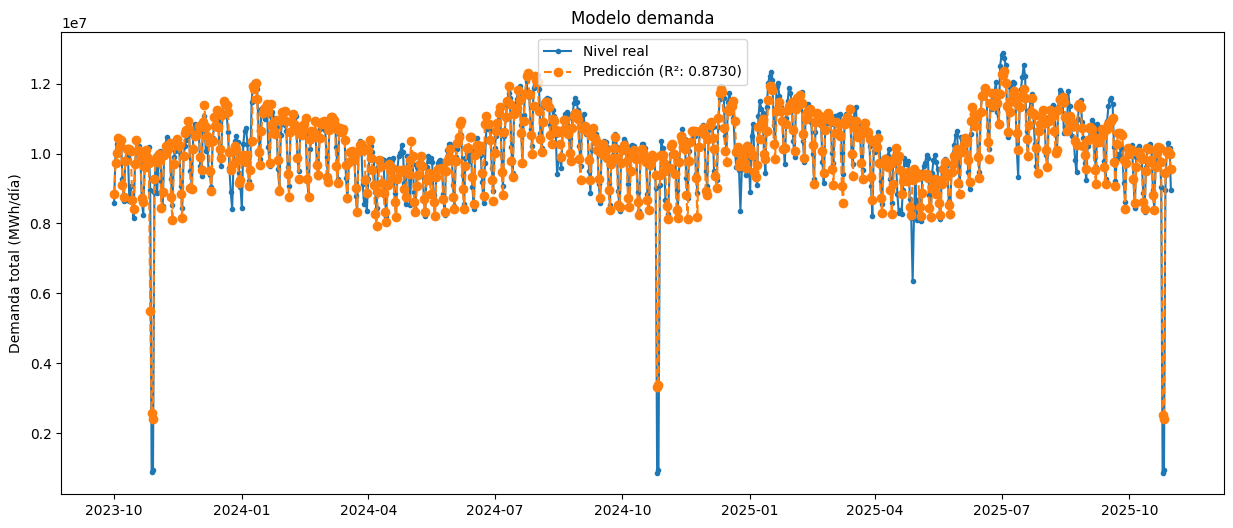

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

agg_dict = {
    'dem': 'sum',
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first'
}

df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={'dem': 'dem_total_dia'})

df_1d['dem_total_lag_7d'] = df_1d['dem_total_dia'].shift(7)
df_1d['dem_total_lag_14d'] = df_1d['dem_total_dia'].shift(14)
df_1d['dem_total_mean_28d'] = df_1d['dem_total_dia'].shift(7).rolling(window=28).mean()

df_1d = df_1d.dropna() 

TARGET_NIVEL = 'dem_total_dia'
FEATURES_NIVEL = [
    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    
    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',
    
    'dem_total_lag_7d',
    'dem_total_lag_14d',
    'dem_total_mean_28d',
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2023-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]

X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_demanda = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=4,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_demanda.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        verbose=100)

MODEL_PATH = '../models/modelo_demanda.json'
model_nivel_demanda.save_model(MODEL_PATH)

preds_nivel = model_nivel_demanda.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo demanda')
plt.ylabel('Demanda total (MWh/día)')
plt.legend()
plt.show()